In [1]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import Dataset
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from utils_train import *
import deepdish as dd
from configs import DatasetConfiguration
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
from sklearn.utils import shuffle

dataset = Dataset('Pcfruit_sensor49')
dataset.read(loadmat=False);
dataset.get_sensor_features(temp_humd=False);
dataset.df_features['y'] = dataset.df_features.filenames.apply(lambda x: x.split('/')[dataset.class_path_idx])
df = dataset.df_features

Species: all.
Read 10264 filenames in 0.03 seconds.


In [3]:
mel_test_dates = ['20191216','20191217','20191220','20191221','20191222','20191223',
                 '20191224','20191225','20191226','20191227','20191228','20191229',
                 '20191230','20191231','20200101','20200102','20200103','20200104',
                 '20200105','20200106',#'20200107','20200108','20200109','20200110',
                 '20200111','20200112','20200113','20200114','20200115','20200116']#,
#                  '20200117','20200118','20200119']
mel_val_dates = ['20200131','20200201','20200307','20200313','20200314','20200315','20200316', '20200107','20200108','20200109','20200110']
suz_test_dates = ['20200207',  '20200219']
suz_val_dates = ['20200209','20200214',  '20200208']

In [4]:
x_test_suz = df[(df.y=='D. suzukii') & (df.datestr.isin(suz_test_dates))].filenames.tolist()
x_test_mel = df[(df.y=='D. melanogaster') & (df.datestr.isin(mel_test_dates))].filenames.tolist()
y_test_suz = df[(df.y=='D. suzukii') & (df.datestr.isin(suz_test_dates))].y.tolist()
y_test_mel = df[(df.y=='D. melanogaster') & (df.datestr.isin(mel_test_dates))].y.tolist()

X_test = x_test_suz+x_test_mel
y_test = y_test_suz+y_test_mel

x_val_suz = df[(df.y=='D. suzukii') & (df.datestr.isin(suz_val_dates))].filenames.tolist()
x_val_mel = df[(df.y=='D. melanogaster') & (df.datestr.isin(mel_val_dates))].filenames.tolist()
y_val_suz = df[(df.y=='D. suzukii') & (df.datestr.isin(suz_val_dates))].y.tolist()
y_val_mel = df[(df.y=='D. melanogaster') & (df.datestr.isin(mel_val_dates))].y.tolist()

X_val = x_val_suz+x_val_mel
y_val = y_val_suz+y_val_mel

In [5]:
X_train = df[~df.filenames.isin(X_test+X_val)].filenames.tolist()
y_train = df[~df.filenames.isin(X_test+X_val)].y.tolist()

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
y_train, y_val, y_test = le.transform(y_train), le.transform(y_val), le.transform(y_test)

In [6]:
print(f"Train: \n{pd.Series(y_train).value_counts()}")
print(f"Val: \n{pd.Series(y_val).value_counts()}")
print(f"Test: \n{pd.Series(y_test).value_counts()}")

Train: 
0    6473
1    1412
dtype: int64
Val: 
0    1272
1     391
dtype: int64
Test: 
0    549
1    167
dtype: int64


In [15]:
traincf = TrainConfiguration(dataset=dataset, setting='psdflt', model_name='mixtesttrain', monitor='val_accuracy')

In [16]:
modelconf = ModelConfiguration(model_setting='conv1d', data_setting='psdflt', target_names=traincf.target_names)

############ INPUT SHAPE:(4097, 1)


In [17]:
model = modelconf.config
model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : weights[i] for i in range(2)}

In [18]:
traingen = train_generator(X_train, y_train, 
                           batch_size=traincf.batch_size,
                           target_names=traincf.target_names,
                           setting=traincf.setting,
                           preprocessing_train_stats='')

valgen = valid_generator(X_val, y_val,
                        batch_size=traincf.batch_size,
                        target_names=traincf.target_names,
                        setting=traincf.setting,
                        preprocessing_train_stats='')

h = model.fit(traingen,
                steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
                epochs = traincf.epochs,
                validation_data = valgen,
                validation_steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))),
                callbacks=traincf.callbacks_list, 
                class_weight=class_weights, 
                verbose=1);

../utils_train.py:141: RuntimeWarning: divide by zero encountered in log10
  _,data = 10*np.log10(signal.welch(data, fs=8000, scaling='density', window='hanning', nfft=8192, nperseg=256, noverlap=128+64))


Epoch 1/100
247/247 [==============================] - ETA: 0s - loss: 0.4556 - accuracy: 0.7862
Epoch 00001: val_accuracy improved from -inf to 0.18614, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/mixtesttrain.h5
247/247 [==============================] - 52s 211ms/step - loss: 0.4556 - accuracy: 0.7862 - val_loss: 1.1882 - val_accuracy: 0.1861 - lr: 0.0010
Epoch 2/100
247/247 [==============================] - ETA: 0s - loss: 0.4255 - accuracy: 0.8224
Epoch 00002: val_accuracy improved from 0.18614 to 0.92391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/mixtesttrain.h5
247/247 [==============================] - 52s 209ms/step - loss: 0.4255 - accuracy: 0.8224 - val_loss: 0.4840 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 3/100
247/247 [==============================] - ETA: 0s - loss: 0.4154 - accuracy: 0.8278
Epoch 00003: val_accuracy did not improve from 0.92391
247/247 [==============================] - 51s 206ms/step - loss: 0

In [19]:
data_setting = 'psdflt'
y_pred = model.predict(valid_generator(X_test, 
                        y_test, 
                        batch_size=128, 
                        setting=data_setting, 
                        target_names=traincf.target_names,
                       preprocessing_train_stats=''),
                    steps = int(math.ceil(float(len(X_test)) / float(128))))

In [20]:
y_pred_argmax = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_argmax).astype(float)

In [21]:
balanced_accuracy_score(y_true=y_test, y_pred=y_pred_argmax)

0.5889696017800464

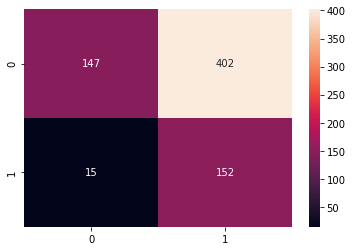

In [22]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='g')